---

# Generate datasets

In [1]:
# import libraries we need
%pylab inline
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from simulation import Simulator

Populating the interactive namespace from numpy and matplotlib


<Figure size 432x288 with 0 Axes>

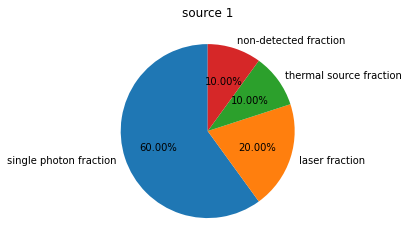

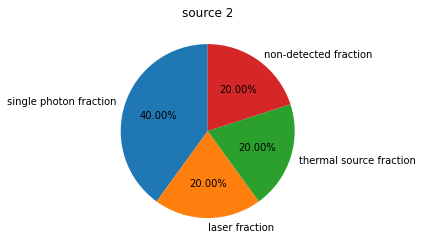

In [2]:
# create two mixed sources and corresponding two distributions
s1 = Simulator.simulator(gt=0.5, Nbins=200, width=1., Ndet=1e6, sps=0.6, laser=0.2, ther=0.1, non=0.1)
s2 = Simulator.simulator(gt=0.5, Nbins=200, width=1., Ndet=1e6, sps=0.4, laser=0.2, ther=0.2, non=0.2)

# plot their piecharts to see source fractions
plt.figure(1)
s1.piechart()
plt.title('source 1')
plt.figure(2)
s2.piechart()
plt.title('source 2')
plt.show()


In [3]:
# set data sets: x-> g2 signal, y -> actual result
# x_train = [] x_test = [] y_train = [] y_test = []
x_ = []
y_ = []
datasets = 500 + 500  # 50 for each distribution, 100 sets in total

In [4]:
# iterate over get_data function to collect data sets   
for i in range(datasets//2): 
    data = s1.get_data(dist=s1.distribution(),save=True, name='s1set'+str(i))
    x_.append(data[0])
    y_.append(data[2])
    
    data = s2.get_data(dist=s2.distribution(),save=True, name='s2set'+str(i))
    x_.append(data[0])
    y_.append(data[2])
    

/home/laserlab/coral/git/CompPhys/g2-coral/simulation/Simulator.py:196: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array([signal, binnumber, np.array([binary])])


 we shuffle the data sets, and then allocate 70% of generated data sets for training the model and 30% for testing 


In [15]:
# convert them to np.array
x_ = np.array(x_)
y_ = np.array(y_)

# shuffle
i = np.random.permutation(len(x_))
x_ = x_[i]
y_ = y_[i]

# reshape
x_ = x_.reshape(x_.shape[0], x_.shape[1], 1)
y_ = y_.reshape(y_.shape[0])

# allocate
x_train = x_[:700]
y_train = y_[:700]
x_test = x_[700:]
y_test = y_[700:]

---
# CNN model

In [6]:
from tensorflow import keras

In [34]:
def make_model(input_shape):
    # input shape should be (time signal, 1)
    input_layer = keras.layers.Input(input_shape)

    # 1st con1d layer
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=4, padding='valid', strides=1, activation='relu')(input_layer)
    
    # 2nd con1d layer
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=4, padding='valid', strides=1, activation='relu')(conv1)

    # 3rd con1d layer
    conv3 = keras.layers.Conv1D(filters=64, kernel_size=4, padding='valid', strides=1, activation='relu')(conv2)
    
    # maxpooling layer
    pool = keras.layers.MaxPool1D(pool_size=3, strides=3, padding='valid')(conv3) # keras.layers.GlobalAveragePooling1D()(conv3) #  # 
    
    # flatten layer
    flat = keras.layers.Flatten()(pool)
    
    # fully connected layer to output a binary vector
    dense1 = keras.layers.Dense(2, activation='relu')(flat)
    #dense2 = keras.layers.Dense(2, activation='relu')(dense1)

    return keras.models.Model(inputs=input_layer, outputs=dense1)


model = make_model(input_shape=x_train.shape[1:])


In [35]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200, 1)]          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 197, 64)           320       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 194, 64)           16448     
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 191, 64)           16448     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 63, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 8066

In [36]:
x_train.shape

(700, 200, 1)

In [37]:
epochs = 200
batch_size = 5

callbacks = [
    # save checkpoints
    keras.callbacks.ModelCheckpoint(
        "g2model.h5", save_best_only=True, monitor="val_loss"
    ),
    
    # if there's no improvement for minimizing losses, which makes the training stagnate
    # then reduce the learning rate
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    
    # stop training if a monitored metric stops improving
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='mse',
    metrics=['sparse_categorical_accuracy'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/200
112/112 [==============================] - 1s 7ms/step - loss: 0.2598 - sparse_categorical_accuracy: 0.4753 - val_loss: 0.2233 - val_sparse_categorical_accuracy: 0.4857
Epoch 2/200
112/112 [==============================] - 1s 6ms/step - loss: 0.1881 - sparse_categorical_accuracy: 0.4248 - val_loss: 0.0059 - val_sparse_categorical_accuracy: 0.5143
Epoch 3/200
112/112 [==============================] - 1s 6ms/step - loss: 0.0031 - sparse_categorical_accuracy: 0.6053 - val_loss: 9.3096e-04 - val_sparse_categorical_accuracy: 0.6571
Epoch 4/200
112/112 [==============================] - 1s 6ms/step - loss: 0.0020 - sparse_categorical_accuracy: 0.7035 - val_loss: 6.2631e-04 - val_sparse_categorical_accuracy: 0.5786
Epoch 5/200
112/112 [==============================] - 1s 6ms/step - loss: 8.8475e-04 - sparse_categorical_accuracy: 0.6867 - val_loss: 0.0019 - val_sparse_categorical_accuracy: 0.7071
Epoch 6/200
112/112 [==============================] - 1s 6ms/step - loss: 0.0010 -

In [38]:
model = keras.models.load_model('g2model.h5')

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)


10/10 [==============================] - 0s 9ms/step - loss: 4.2368e-04 - sparse_categorical_accuracy: 0.7233
Test accuracy 0.7233333587646484
Test loss 0.0004236767708789557


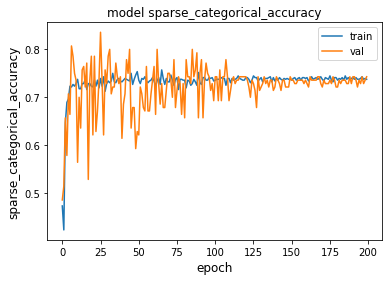

In [43]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()
